In [1]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Hide warning messages in notebook
import warnings
#warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')


In [3]:
# File to Load (Remember to Change These)
mouse_drug_data_to_load = "data/mouse_drug_data.csv"
clinical_trial_data_to_load = "data/clinicaltrial_data.csv"

In [4]:
# Read the Mouse and Drug Data and the Clinical Trial Data
clinical_data = pd.read_csv(clinical_trial_data_to_load)
mouse_data = pd.read_csv(mouse_drug_data_to_load)
clinical_data.head()


,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites
0,b128,0,45.0,0
1,f932,0,45.0,0
2,g107,0,45.0,0
3,a457,0,45.0,0
4,c819,0,45.0,0


In [5]:
mouse_data.head()

,Mouse ID,Drug
0,f234,Stelasyn
1,x402,Stelasyn
2,a492,Stelasyn
3,w540,Stelasyn
4,v764,Stelasyn


# Examine the dataset to ensure it matches the characteristics (250 mice and 4 specific drugs for treatment) as described in the problem set

In [6]:
# Examine dataset as compared to the information in project intro - 250 mice in the study
nr_mice_ids = len(mouse_data['Mouse ID'])
unique_mice = mouse_data['Mouse ID'].nunique()
print(f'The number of mice IDs is: {nr_mice_ids}')
print(f'The number of unique mice IDs is: {unique_mice}')

The number of mice IDs is: 250
The number of unique mice IDs is: 249


In [7]:
# Identify the duplicate Mouse ID...this duplicate mouse ID must be an error in the data (each mouse only received a single drug)
# and will need to be removed from the cleaned, combined data set

duplicate_mouse_id = mouse_data[mouse_data.duplicated(['Mouse ID'],keep=False)]
duplicate_mouse_id

,Mouse ID,Drug
7,g989,Stelasyn
173,g989,Propriva


In [8]:
# Also examine the dataset for the drug names...just checking to see that the 4 drugs that the problem set wants to search 
    # are present in the dataset (Capomulin, Infubinol, Ketapril and Placebo)...success

drug_list = mouse_data.Drug.unique()
drug_list

array(['Stelasyn', 'Naftisol', 'Ketapril', 'Capomulin', 'Infubinol',
       'Ceftamin', 'Propriva', 'Zoniferol', 'Ramicane', 'Placebo'],
      dtype=object)

In [9]:
# Combine the data into a single dataset
combined_data = pd.merge(clinical_data, mouse_data, how="inner", on=["Mouse ID"])

# Display the data table for preview
combined_data.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug
0,b128,0,45.000000,0,Capomulin
1,b128,5,45.651331,0,Capomulin
2,b128,10,43.270852,0,Capomulin
3,b128,15,43.784893,0,Capomulin
4,b128,20,42.731552,0,Capomulin


In [10]:
# Rename the 'Mouse ID' column to 'Mouse_ID' --> had to do this as I had difficulty using 'Mouse ID' without the underscore
    # in the subsequent command to drop the duplicate mouse id

combined_data.rename(columns={'Mouse ID':'Mouse_ID'}, inplace=True)
combined_data.head()

,Mouse_ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug
0,b128,0,45.000000,0,Capomulin
1,b128,5,45.651331,0,Capomulin
2,b128,10,43.270852,0,Capomulin
3,b128,15,43.784893,0,Capomulin
4,b128,20,42.731552,0,Capomulin


In [11]:
# Remove the rows of 'bad data' by removing the duplicate Mouse ID identified above --> g989

combined_data_clean = combined_data[combined_data.Mouse_ID != 'g989']
combined_data_clean.head()

,Mouse_ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug
0,b128,0,45.000000,0,Capomulin
1,b128,5,45.651331,0,Capomulin
2,b128,10,43.270852,0,Capomulin
3,b128,15,43.784893,0,Capomulin
4,b128,20,42.731552,0,Capomulin


In [12]:
# Group the clean data by 'Mouse ID'
mouse_id_group = combined_data_clean.groupby(['Mouse_ID'])


In [13]:
# Count the  total number of Mouse ID elements...was 1906 before removal of the duplicate Mouse ID, which should remove 26 
    # elements
combined_data_clean['Mouse_ID'].count()


1880

## Tumor Response to Treatment

In [14]:
# Store the Mean Tumor Volume Data Grouped by Drug and Timepoint 
data_clean_group = combined_data_clean.groupby(['Drug', 'Timepoint']) #, as_index=False)
tumor_vol_grp_mean = data_clean_group['Tumor Volume (mm3)'].mean()
tumor_vol_grp_mean.head()


Drug       Timepoint
Capomulin  0            45.000000
           5            44.266086
           10           43.084291
           15           42.064317
           20           40.716325
Name: Tumor Volume (mm3), dtype: float64

In [15]:
# Convert to DataFrame...add reset_index otherwise errors with the 'data munging' pivot on this df
tumor_vol_df = pd.DataFrame(tumor_vol_grp_mean).reset_index() # reset_index effectively unstacks the groupby Drug and Timepoint

# Preview DataFrame
tumor_vol_df.head()

,Drug,Timepoint,Tumor Volume (mm3)
0,Capomulin,0,45.000000
1,Capomulin,5,44.266086
2,Capomulin,10,43.084291
3,Capomulin,15,42.064317
4,Capomulin,20,40.716325


In [16]:
# Store the Standard Error of Mean of Tumor Volumes Grouped by Drug and Timepoint
sem_tumor = data_clean_group.sem()['Tumor Volume (mm3)']

# Convert to DataFrame
sem_tumor_df = pd.DataFrame(sem_tumor).reset_index()

# Preview DataFrame
sem_tumor_df.head()

,Drug,Timepoint,Tumor Volume (mm3)
0,Capomulin,0,0.000000
1,Capomulin,5,0.448593
2,Capomulin,10,0.702684
3,Capomulin,15,0.838617
4,Capomulin,20,0.909731


In [17]:
# Minor Data Munging to Re-Format the Tumor Volume Data Frame and Pivot on Timepoint &  Drug
tumor_vol_df_pivot = tumor_vol_df.pivot(index='Timepoint', columns='Drug')

# Preview that Reformatting worked...NOTE: Must have reset_index on the tumor_vol_df above for this pivot to work
tumor_vol_df_pivot


Tumor Volume (mm3)                                              \
Drug               Capomulin   Ceftamin  Infubinol   Ketapril   Naftisol   
Timepoint                                                                  
0                  45.000000  45.000000  45.000000  45.000000  45.000000   
5                  44.266086  46.503051  47.062001  47.389175  46.796098   
10                 43.084291  48.285125  49.403909  49.582269  48.694210   
15                 42.064317  50.094055  51.296397  52.399974  50.933018   
20                 40.716325  52.157049  53.197691  54.920935  53.644087   
25                 39.939528  54.287674  55.715252  57.678982  56.731968   
30                 38.769339  56.769517  58.299397  60.994507  59.559509   
35                 37.816839  58.827548  60.742461  63.371686  62.685087   
40                 36.958001  61.467895  63.162824  66.068580  65.600754   
45                 36.236114  64.132421  65.755562  70.662958  69.265506   

                                                                  
Drug         Placebo   Propriva   Ramicane   Stelasyn  Zoniferol  
Timepoint                                                         
0          45.000000  45.000000  45.000000  45.000000  45.000000  
5          47.125589  47.168130  43.944859  47.470830  46.851818  
10         49.423329  48.938560  42.531957  49.335368  48.689881  
15         51.359742  50.891769  41.495061  51.448025  50.779059  
20         54.364417  53.127384  40.238325  53.970080  53.170334  
25         57.482574  55.462490  38.974300  56.172821  55.432935  
30         59.809063  58.122548  38.703137  59.870528  57.713531  
35         62.420615  60.103457  37.451996  62.432021  60.089372  
40         65.052675  63.045537  36.574081  65.356386  62.916692  
45         68.084082  66.258529  34.955595  68.438310  65.960888

In [18]:
# Minor Data Munging to Re-Format the Tumor Volume SEM Data Frame and Pivot on Timepoint &  Drug
sem_tumor_df_pivot = sem_tumor_df.pivot(index='Timepoint', columns='Drug')

# Preview that Reformatting worked...NOTE: Must have reset_index on the sem_tumor_df above for this pivot to work
sem_tumor_df_pivot

Tumor Volume (mm3)                                          \
Drug               Capomulin  Ceftamin Infubinol  Ketapril  Naftisol   
Timepoint                                                              
0                   0.000000  0.000000  0.000000  0.000000  0.000000   
5                   0.448593  0.164505  0.235102  0.264819  0.202385   
10                  0.702684  0.236144  0.282346  0.357421  0.319415   
15                  0.838617  0.332053  0.357705  0.580268  0.444378   
20                  0.909731  0.359482  0.476210  0.726484  0.595260   
25                  0.881642  0.439356  0.550315  0.755413  0.813706   
30                  0.934460  0.490620  0.631061  0.934121  0.975496   
35                  1.052241  0.692248  0.984155  1.127867  1.013769   
40                  1.223608  0.708505  1.055220  1.158449  1.118567   
45                  1.223977  0.902358  1.144427  1.453186  1.416363   

                                                             
Drug        Placebo  Propriva  Ramicane  Stelasyn Zoniferol  
Timepoint                                                    
0          0.000000  0.000000  0.000000  0.000000  0.000000  
5          0.218091  0.241842  0.482955  0.254830  0.188950  
10         0.402064  0.388701  0.720225  0.461474  0.263949  
15         0.614461  0.502024  0.770432  0.532904  0.370544  
20         0.839609  0.607412  0.786199  0.684670  0.533182  
25         1.034872  0.622040  0.746991  0.784320  0.602513  
30         1.218231  0.807055  0.864906  0.952984  0.800043  
35         1.287481  1.181202  0.967433  1.072411  0.881426  
40         1.370634  1.564779  1.128445  1.410435  0.998515  
45         1.351726  1.888586  1.226805  1.576556  1.003576

In [19]:
# Examine the SEMs for a single drug, Capomulin...just testing functionality of the pivoted frame
sem_tumor_df_pivot['Tumor Volume (mm3)']['Capomulin']

Timepoint
0     0.000000
5     0.448593
10    0.702684
15    0.838617
20    0.909731
25    0.881642
30    0.934460
35    1.052241
40    1.223608
45    1.223977
Name: Capomulin, dtype: float64

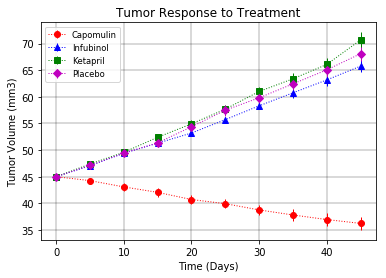

In [20]:
# Generate the Plot (with Error Bars)

# Place an errobar chart for each of the 3 drugs (Capomulin, Infubinol, Ketapril) and Placebo
plt.errorbar(sem_tumor_df_pivot.index, tumor_vol_df_pivot['Tumor Volume (mm3)']['Capomulin'],
             sem_tumor_df_pivot['Tumor Volume (mm3)']['Capomulin'], linestyle=':', fmt='o', color='r', linewidth=1,
             label='Capomulin')

plt.errorbar(sem_tumor_df_pivot.index, tumor_vol_df_pivot['Tumor Volume (mm3)']['Infubinol'],
             sem_tumor_df_pivot['Tumor Volume (mm3)']['Infubinol'], linestyle=':', fmt='^', color='b', linewidth=1,
             label='Infubinol')

plt.errorbar(sem_tumor_df_pivot.index, tumor_vol_df_pivot['Tumor Volume (mm3)']['Ketapril'],
             sem_tumor_df_pivot['Tumor Volume (mm3)']['Ketapril'], linestyle=':', fmt='s', color='g', linewidth=1,
             label='Ketapril')

plt.errorbar(sem_tumor_df_pivot.index, tumor_vol_df_pivot['Tumor Volume (mm3)']['Placebo'],
             sem_tumor_df_pivot['Tumor Volume (mm3)']['Placebo'], linestyle=':', fmt='D', color='m', linewidth=1,
             label='Placebo')

# Format the chart elements: legend,  gridlines, title, axis labels:

plt.legend(loc='best', fontsize='small')
plt.grid(color='k', linestyle='-', linewidth=.3)
plt.title('Tumor Response to Treatment')
plt.xlabel('Time (Days)')
plt.ylabel('Tumor Volume (mm3)')

#Save the figure
plt.savefig('Tumor Response to Treatment')

#Show the plot
plt.show()


## Metastatic Response to Treatment

In [21]:
# Store the Mean Met. Site Data Grouped by Drug and Timepoint 

#data_clean_group = combined_data_clean.groupby(['Drug', 'Timepoint']) #, as_index=False)
meta_sites_grp_mean = data_clean_group['Metastatic Sites'].mean()

# Convert to DataFrame... as with the tumor_vol_grp above, apply the reset_index to this df
meta_sites_df = pd.DataFrame(meta_sites_grp_mean).reset_index()

# Preview DataFrame
meta_sites_df.head()


,Drug,Timepoint,Metastatic Sites
0,Capomulin,0,0.000000
1,Capomulin,5,0.160000
2,Capomulin,10,0.320000
3,Capomulin,15,0.375000
4,Capomulin,20,0.652174


In [22]:
# Store the Standard Error associated with Met. Sites Grouped by Drug and Timepoint 
sem_meta_sites = data_clean_group.sem()['Metastatic Sites']

# Convert to DataFrame
sem_meta_sites_df = pd.DataFrame(sem_meta_sites).reset_index()

# Preview DataFrame
sem_meta_sites_df.head()


,Drug,Timepoint,Metastatic Sites
0,Capomulin,0,0.000000
1,Capomulin,5,0.074833
2,Capomulin,10,0.125433
3,Capomulin,15,0.132048
4,Capomulin,20,0.161621


In [23]:
# Minor Data Munging to Re-Format the Metastatic Sites Mean Data Frame and Pivot on Timepoint &  Drug

# Preview that Reformatting worked
meta_sites_df_pivot = meta_sites_df.pivot(index='Timepoint', columns='Drug')
meta_sites_df_pivot.head()

Metastatic Sites                                                    \
Drug             Capomulin  Ceftamin Infubinol  Ketapril  Naftisol   Placebo   
Timepoint                                                                      
0                 0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5                 0.160000  0.380952  0.280000  0.304348  0.260870  0.375000   
10                0.320000  0.600000  0.666667  0.590909  0.523810  0.833333   
15                0.375000  0.789474  0.904762  0.842105  0.857143  1.250000   
20                0.652174  1.111111  1.050000  1.210526  1.150000  1.526316   

                                                   
Drug       Propriva  Ramicane  Stelasyn Zoniferol  
Timepoint                                          
0          0.000000  0.000000  0.000000  0.000000  
5          0.347826  0.120000  0.260870  0.166667  
10         0.619048  0.250000  0.523810  0.500000  
15         0.800000  0.333333  0.809524  0.809524  
20         1.000000  0.347826  0.947368  1.294118

In [24]:
# Minor Data Munging to Re-Format the Metastatic Sites SEM Data Frame and Pivot on Timepoint &  Drug
sem_meta_sites_df_pivot = sem_meta_sites_df.pivot(index='Timepoint', columns='Drug')

# Preview that Reformatting worked
sem_meta_sites_df_pivot.head()


Metastatic Sites                                                    \
Drug             Capomulin  Ceftamin Infubinol  Ketapril  Naftisol   Placebo   
Timepoint                                                                      
0                 0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5                 0.074833  0.108588  0.091652  0.098100  0.093618  0.100947   
10                0.125433  0.152177  0.159364  0.142018  0.163577  0.115261   
15                0.132048  0.180625  0.194015  0.191381  0.158651  0.190221   
20                0.161621  0.241034  0.234801  0.236680  0.181731  0.234064   

                                                   
Drug       Propriva  Ramicane  Stelasyn Zoniferol  
Timepoint                                          
0          0.000000  0.000000  0.000000  0.000000  
5          0.101543  0.066332  0.093618  0.077709  
10         0.108588  0.090289  0.131277  0.109109  
15         0.144749  0.115261  0.163577  0.111677  
20         0.195180  0.119430  0.222607  0.166378

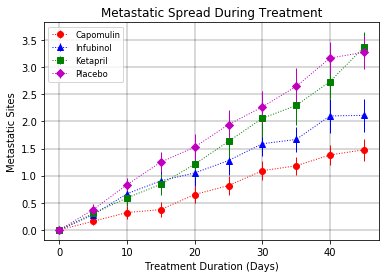

In [25]:
# Generate the Metastatic Sites Plot (with Error Bars)

# Place an errobar chart for each of the 3 drugs (Capomulin, Infubinol, Ketapril) and Placebo
plt.errorbar(sem_meta_sites_df_pivot.index, meta_sites_df_pivot['Metastatic Sites']['Capomulin'],
             sem_meta_sites_df_pivot['Metastatic Sites']['Capomulin'], linestyle=':', fmt='o', color='r', linewidth=1,
             label='Capomulin')

plt.errorbar(sem_meta_sites_df_pivot.index, meta_sites_df_pivot['Metastatic Sites']['Infubinol'],
             sem_meta_sites_df_pivot['Metastatic Sites']['Infubinol'], linestyle=':', fmt='^', color='b', linewidth=1,
             label='Infubinol')

plt.errorbar(sem_meta_sites_df_pivot.index, meta_sites_df_pivot['Metastatic Sites']['Ketapril'],
             sem_meta_sites_df_pivot['Metastatic Sites']['Ketapril'], linestyle=':', fmt='s', color='g', linewidth=1,
             label='Ketapril')

plt.errorbar(sem_meta_sites_df_pivot.index, meta_sites_df_pivot['Metastatic Sites']['Placebo'],
             sem_meta_sites_df_pivot['Metastatic Sites']['Placebo'], linestyle=':', fmt='D', color='m', linewidth=1,
             label='Placebo')

# Format the chart elements: legend,  gridlines, title, axis labels

plt.legend(loc='best', fontsize='small')
plt.grid(color='k', linestyle='-', linewidth=.3)
plt.title('Metastatic Spread During Treatment')
plt.xlabel('Treatment Duration (Days)')
plt.ylabel('Metastatic Sites')

# Save the Figure
plt.savefig('Metastatic sites')

# Show the Figure
plt.show()

## Survival Rates

In [26]:
# Store the Count of Mice Grouped by Drug and Timepoint (W can pass any metric)
    # Note:  data_clean_group was grouped by Drug and Timepoint above, so no need to repeat
mouse_count = data_clean_group['Mouse_ID'].count()

# Convert to DataFrame
mouse_count_df = pd.DataFrame(mouse_count).reset_index()

# Rename Mouse_ID column to Mouse Count in this new DataFrame
mouse_count_df.rename(columns={'Mouse_ID':'Mouse Count'}, inplace=True)

# Preview DataFrame
mouse_count_df.head()


,Drug,Timepoint,Mouse Count
0,Capomulin,0,25
1,Capomulin,5,25
2,Capomulin,10,25
3,Capomulin,15,24
4,Capomulin,20,23


In [27]:
# Minor Data Munging to Re-Format the Data Frames
mouse_count_df_pivot = mouse_count_df.pivot(index='Timepoint', columns='Drug')

# Preview the Data Frame...Note: Propriva and Stelasyn start with one fewer mouse than the other drugs due to the bad data 
# removed above...mouse ID g989
mouse_count_df_pivot.head()


Mouse Count                                                        \
Drug        Capomulin Ceftamin Infubinol Ketapril Naftisol Placebo Propriva   
Timepoint                                                                     
0                  25       25        25       25       25      25       24   
5                  25       21        25       23       23      24       23   
10                 25       20        21       22       21      24       21   
15                 24       19        21       19       21      20       15   
20                 23       18        20       19       20      19       15   

                                       
Drug      Ramicane Stelasyn Zoniferol  
Timepoint                              
0               25       24        25  
5               25       23        24  
10              24       21        22  
15              24       21        21  
20              23       19        17

In [28]:
mouse_count_df_pivot

Mouse Count                                                        \
Drug        Capomulin Ceftamin Infubinol Ketapril Naftisol Placebo Propriva   
Timepoint                                                                     
0                  25       25        25       25       25      25       24   
5                  25       21        25       23       23      24       23   
10                 25       20        21       22       21      24       21   
15                 24       19        21       19       21      20       15   
20                 23       18        20       19       20      19       15   
25                 22       18        18       19       18      17       13   
30                 22       16        17       18       15      15       12   
35                 22       14        12       17       15      14        9   
40                 21       14        10       15       15      12        9   
45                 21       13         9       11       13      11        7   

                                       
Drug      Ramicane Stelasyn Zoniferol  
Timepoint                              
0               25       24        25  
5               25       23        24  
10              24       21        22  
15              24       21        21  
20              23       19        17  
25              23       18        16  
30              23       17        15  
35              21       15        14  
40              20       12        14  
45              20       11        14

In [29]:
# Create variables for the starting mouse counts for each of the relevant drugs & placebo...makes the plot code slightly
    # easier to read

starting_mouse_count_capo = mouse_count_df_pivot['Mouse Count']['Capomulin'][0]
starting_mouse_count_infu = mouse_count_df_pivot['Mouse Count']['Infubinol'][0]
starting_mouse_count_keta = mouse_count_df_pivot['Mouse Count']['Ketapril'][0]
starting_mouse_count_plac = mouse_count_df_pivot['Mouse Count']['Placebo'][0]


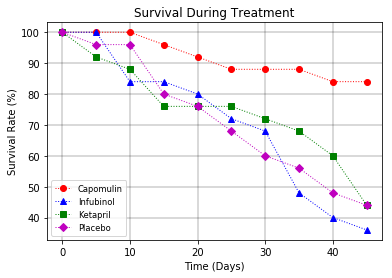

In [30]:
# Generate the Plot (Accounting for percentages)

plt.errorbar(mouse_count_df_pivot.index, mouse_count_df_pivot['Mouse Count']['Capomulin']/starting_mouse_count_capo*100,
             linestyle=':', fmt='o', color='r', linewidth=1, label='Capomulin')

plt.errorbar(mouse_count_df_pivot.index, mouse_count_df_pivot['Mouse Count']['Infubinol']/starting_mouse_count_infu*100,
             linestyle=':', fmt='^', color='b', linewidth=1, label='Infubinol')

plt.errorbar(mouse_count_df_pivot.index, mouse_count_df_pivot['Mouse Count']['Ketapril']/starting_mouse_count_keta*100,
             linestyle=':', fmt='s', color='g', linewidth=1, label='Ketapril')

plt.errorbar(mouse_count_df_pivot.index, mouse_count_df_pivot['Mouse Count']['Placebo']/starting_mouse_count_plac*100,
             linestyle=':', fmt='D', color='m', linewidth=1, label='Placebo')

# Format the chart elements: legend,  gridlines, title, axis labels:

plt.legend(loc='best', fontsize='small')
plt.grid(color='k', linestyle='-', linewidth=.3)
plt.title('Survival During Treatment')
plt.xlabel('Time (Days)')
plt.ylabel('Survival Rate (%)')

# Save the Figure
plt.savefig('Survival Rates.png')

# Show the Figure
plt.show()

## Summary Bar Graph

In [31]:
# Calculate the percent changes for each drug

percent_change_tumor_vol = (tumor_vol_df_pivot.loc[45]/tumor_vol_df_pivot.loc[0]-1)*100

# Display the data to confirm
percent_change_tumor_vol


                    Drug     
Tumor Volume (mm3)  Capomulin   -19.475303
                    Ceftamin     42.516492
                    Infubinol    46.123472
                    Ketapril     57.028795
                    Naftisol     53.923347
                    Placebo      51.297960
                    Propriva     47.241175
                    Ramicane    -22.320900
                    Stelasyn     52.085134
                    Zoniferol    46.579751
dtype: float64

In [32]:
# Store all Relevant Percent Changes into a Tuple

# Store all Relevant Percent Changes into a Tuple
changes_tuple = tuple(percent_change_tumor_vol)
changes_tuple


(-19.475302667894155,
 42.51649185589741,
 46.12347172785185,
 57.02879468660604,
 53.92334713476919,
 51.29796048315151,
 47.24117486320634,
 -22.32090046276666,
 52.085134287899,
 46.57975086509523)

In [33]:
# Splice the data between passing and failing drugs
passing_drugs = []
failing_drugs = []

for i in drug_list:
    if percent_change_tumor_vol['Tumor Volume (mm3)'][i] < 0:
        passing_drugs.append(i)
    else:
        failing_drugs.append(i)


In [34]:
print(f'Passing Drugs are: {passing_drugs}')
print(f'Failing Drugs are: {failing_drugs}')

Passing Drugs are: ['Capomulin', 'Ramicane']
Failing Drugs are: ['Stelasyn', 'Naftisol', 'Ketapril', 'Infubinol', 'Ceftamin', 'Propriva', 'Zoniferol', 'Placebo']


In [35]:
# Convert percent_change_tumor_vol from a multi-level series into a data frame

percent_change_tumor_vol_df = percent_change_tumor_vol.unstack(level=0)

# Reset the index of the percent_change_tumor_vol_df

percent_change_tumor_vol_df = percent_change_tumor_vol_df.reset_index()

# Rename the Tumor Volume (mm3) column to % Change to correctly label the data
percent_change_tumor_vol_df.rename(columns={'Tumor Volume (mm3)': '% Change'},inplace=True)

percent_change_tumor_vol_df

,Drug,% Change
0,Capomulin,-19.475303
1,Ceftamin,42.516492
2,Infubinol,46.123472
3,Ketapril,57.028795
4,Naftisol,53.923347
5,Placebo,51.297960
6,Propriva,47.241175
7,Ramicane,-22.320900
8,Stelasyn,52.085134
9,Zoniferol,46.579751


In [38]:
percent_change_tumor_vol_subset_df = percent_change_tumor_vol_df.loc[[0,2,3,5]]
percent_change_tumor_vol_subset_df.reset_index(inplace=True, drop=True)
percent_change_tumor_vol_subset_df


,Drug,% Change
0,Capomulin,-19.475303
1,Infubinol,46.123472
2,Ketapril,57.028795
3,Placebo,51.297960


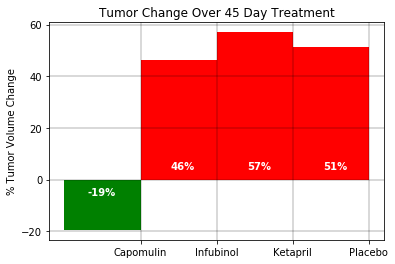

In [39]:
#make bar chart

# Major ticks every 20
major_ticks = np.arange(-20, 70, 20)

for i in percent_change_tumor_vol_subset_df.index:
    if percent_change_tumor_vol_subset_df['% Change'].loc[i] < 0:
        plt.bar(percent_change_tumor_vol_subset_df.loc[i,['Drug']], percent_change_tumor_vol_subset_df.loc[i,['% Change']],
                color='g', align='edge', width = -1)
        plt.text(-.7, -6, str(int(round(percent_change_tumor_vol_subset_df['% Change'].loc[i]))) + '%',color = 'w',
                weight = 'bold')
    else:
        plt.bar(percent_change_tumor_vol_subset_df.loc[i,['Drug']], percent_change_tumor_vol_subset_df.loc[i,['% Change']],
                color='r', align='edge', width = -1)
        plt.text(i -.6, 4, str(int(round(percent_change_tumor_vol_subset_df['% Change'].loc[i]))) + '%',color='w',
                 weight = 'bold')

plt.yticks(major_ticks) # adjusts the y-ticks to step in qty of 20
plt.grid(color='k', linestyle='-', linewidth=.3)
plt.ylabel('% Tumor Volume Change')
plt.title('Tumor Change Over 45 Day Treatment')

# Save the Figure

plt.savefig('Tumor Change')

# Show the Figure

plt.show()



# Observable Trends

    # 1. From the Tumor Response to Treatment errorbar/line Chart, we can see that most of the drugs and the placebo did not
        # reduce the mean Tumor Volume during the 45 day period.  In fact, only two drugs (Capomulin and Ramicane) 
        # successfully reduced mean tumor volume during the period.  The other 7 and the placebo failed to reduce mean 
        # tumor volume during the period.
        
    # 2. From the Metastatic Spread During Treatment errorbar/line chart, we can see that Capomulin (and Ramicane was even
        # better) evidences the slowest mean spread of metastatic sites during the period...less than half the mean # of sites
        # compared with the worst performing drugs and the placebo.  
        
    # 3. From the Survival During Treatment errorbar/line chart, we can see that mice receiving Capomulin (and Ramicane)
        # had a far higher survival rate (84%) during the period than the other drugs and the placebo (all below 60% survival
        # rate, with Propriva the worst at 28%).